In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
import tensorflow as tf
import math

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from plotly.offline import plot
from plotly.offline import init_notebook_mode

# https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output


# 3년 간의 기상 관측 데이터

# Hour - 시간
# Minute - 분
# DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
# DNI - 직달일사량(Direct Normal Irradiance (W/m2))
# WS - 풍속(Wind Speed (m/s))
# RH - 상대습도(Relative Humidity (%))
# T - 기온(Temperature (Degree C))
# Target - 태양광 발전량 (kW)

# 0~6일 간의 데이터로 7, 8일의 Target 예측


# 1. 습도는 당연히 100이 최대
# 2. 온도는 최하 영하 19도, 최고 영상 35도까지만 측정 가능한 것으로 보임
#    2-1 : 엉하 19도 관측값 1개 | 영상 35도 관측값 9개
#    2-2 : 범위 제한을 풀기 위해 각 임계값에서 아주 작은 값을 더하고 빼자.
# 3. 온도는 Integer...

# Feature Engineering 
# 1. Vap : 단위면적 당 수증기 량
# 2. DP : 이슬점
# 3. GHI : DHI + (DNI * cos(theta))
# 4. WT : 습구온도

In [21]:
def GHI(data) :
    
    d = data["Day"] % 365
    longitude  = 37.532600
    Tutc = 9
    LSTM = 15 * Tutc
    B = (360 / 365) * (d - 81)
    EoT = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)
    TC = 4 * (127.024612 - LSTM) + EoT
    LST = data["Hour"] + (TC / 60)
    LST[np.array(range(1, LST.shape[0], 2))] += 0.7
    HRA = 15 * (LST- 12)

    theta = np.arcsin(np.sin(23.45) * np.sin(B))
    alpha = np.arcsin(np.sin(theta) * np.sin(longitude) + np.cos(theta) * np.cos(longitude) * np.cos(HRA))
    Zenith = 90 - alpha
    GHI = data["DHI"] + (data["DNI"] * Zenith)
    data.loc[:, "GHI"] = GHI
    
    return

def applyFeatureEngineering(data) :
    
    VaporTable = pd.DataFrame(np.array([0.9673, 1.0595, 1.1596, 1.2679, 1.3856, 1.5133,
                                    1.6517, 1.8010, 1.9632, 2.1379, 2.3267, 2.5314, 2.7516, 2.9888, 3.2444, 3.5199, 3.8167, 4.1352, 4.4777, 
                                    4.8467, 5.1917, 5.5579, 5.9466, 6.3588, 6.7958, 7.2589, 7.7494, 8.2686, 8.8171, 9.3977, 
                                    10.0110, 10.6590, 11.3430, 12.0650, 12.8270, 13.6290, 14.4750, 15.3660, 15.5620, 17.2910, 18.3290, 19.4210,
                                    20.5680, 21.7730, 23.0380, 24.3660, 25.7660, 27.2210, 28.7560, 30.3580, 32.0390, 33.7990, 35.6410, 37.5680, 39.5830]),
                          index = list(range(-19, 36)))

    data.loc[:, "DNI"] = np.log(data["DNI"] + 1)
    data.loc[:, "DHI"] = np.log(data["DHI"] + 1)
    data.loc[:, "WS"] = np.log(data["WS"] + 1)
    GHI(data)
    data.loc[:, "RH"] /= 100
    data.loc[:, "Vap"] = VaporTable.loc[train["T"]].values * data["RH"].values.reshape(-1, 1)
    formula = np.log(data["RH"]) + (17.62 * data["T"]) / (243.12 + data["T"])
    data.loc[:, "DP"] = (243.12 * formula) / (17.62 - formula)
    data.loc[:, "Dew"] = data["T"] - data["DP"]
    data.loc[:, "WT"] = data["T"] - (data["Dew"] / 3)
    data = data[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "Vap", "GHI", "DP", "Dew", "WT", "TARGET"]]
    data.loc[:, "HI"] = data["DHI"] - data["DNI"]
#    data = pd.concat([data, data.rolling(window = interval, min_periods = 1).mean().drop(["Day", "Hour", "Minute"], axis = "columns").add_suffix("_AVG")], axis = 1)    
    return data
train = pd.read_csv("./RawData/train/train.csv")

train = applyFeatureEngineering(train)

train.index = pd.date_range("2000-01-01 00:00", periods = train.shape[0], freq = "30T")
train = train[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "Vap", "GHI", "DP", "Dew", "WT", "HI", "TARGET"]]
train["NEW_TARGET"] = train["TARGET"].slice_shift(96)
train = train.dropna()
train.describe()


Day          Hour        Minute           DHI           DNI  \
count  52464.000000  52464.000000  52464.000000  52464.000000  52464.000000   
mean     548.000000     11.500000     15.000000      2.220364      2.514360   
std      315.524797      6.922253     15.000143      2.344519      3.013980   
min        2.000000      0.000000      0.000000      0.000000      0.000000   
25%      275.000000      5.750000      0.000000      0.000000      0.000000   
50%      548.000000     11.500000     15.000000      0.000000      0.000000   
75%      821.000000     17.250000     30.000000      4.477337      6.152733   
max     1094.000000     23.000000     30.000000      6.270988      6.966024   

                 RH            WS             T           Vap           GHI  \
count  52464.000000  52464.000000  52464.000000  52464.000000  52464.000000   
mean       0.567648      1.161197      9.309984      5.171438    228.508536   
std        0.220584      0.397681     10.163261      2.704664    273.260098   
min        0.075900      0.000000    -19.000000      0.548158      0.000000   
25%        0.396600      0.875469      1.000000      3.115020      0.000000   
50%        0.575600      1.163151      9.000000      4.469343      0.000000   
75%        0.727500      1.435085     17.000000      6.882901    558.345256   
max        1.000000      2.564949     35.000000     14.602310    640.365392   

                 DP           Dew            WT        TARGET    NEW_TARGET  
count  52464.000000  5.246400e+04  52464.000000  52464.000000  52464.000000  
mean      -0.266026  9.576010e+00      6.117981     17.807131     17.805046  
std        7.694153  7.027416e+00      8.810235     25.773169     25.773161  
min      -26.075522 -1.776357e-15    -20.756755      0.000000      0.000000  
25%       -5.705394  4.428431e+00     -1.041777      0.000000      0.000000  
50%       -0.635945  7.697779e+00      5.909761      0.000000      0.000000  
75%        5.804944  1.335070e+01     13.308707     32.180978     32.096062  
max       17.220399  3.692668e+01     25.808581     99.913939     99.913939

In [23]:
class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [24]:
scaler = DecimalScaler()
train = pd.DataFrame(scaler.fit_transform(train), index = train.index, columns = train.columns)

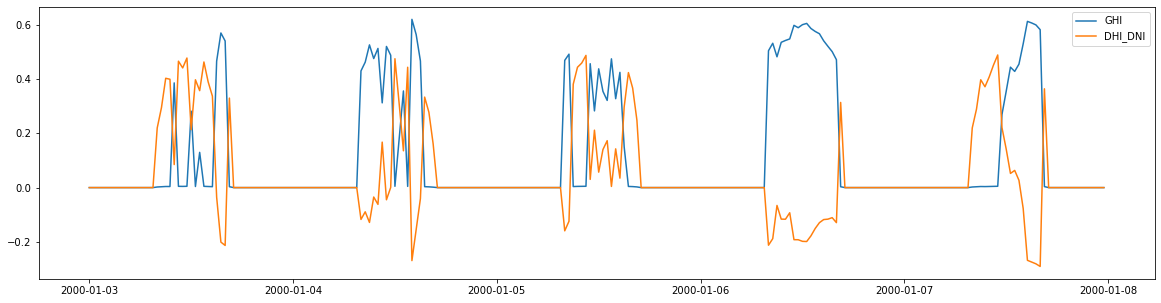

In [35]:
start = 0
end = 48 * 5
plt.figure(figsize = (20, 5))
plt.plot(train["GHI"][start:end], label = "GHI")
#plt.plot(train["DNI"][start:end], label = "DNI")
#plt.plot(train["DHI"][start:end], label = "DHI")
plt.plot((train["DHI"] - train["DNI"])[start:end], label = "DHI_DNI")
#plt.plot(train["TARGET"][start:end], label = "Target", c = "red")
#plt.plot(train["T"][start:end], label = "Temp")
#plt.plot(train["WS"][start:end], label = "Humid")

plt.legend()

In [64]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(inputSeries):
    result = adfuller(inputSeries, maxlag = 1)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print_adfuller(train["TARGET"][:48*10])
print("--------")


ADF Statistic: -4.360102
p-value: 0.000349
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
--------


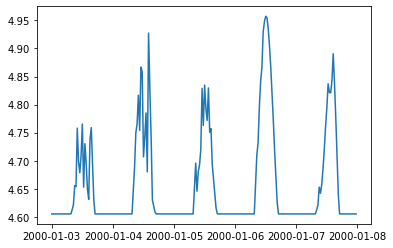

In [51]:
test = (train["TARGET"] - train["TARGET"].shift(5)).dropna()
#test[:96].plot(figsize = (20, 5))

plt.plot(np.log(train["TARGET"]+100)[:48*5])

array([[<AxesSubplot:title={'center':'Day'}>,
        <AxesSubplot:title={'center':'Hour'}>,
        <AxesSubplot:title={'center':'Minute'}>,
        <AxesSubplot:title={'center':'DHI'}>],
       [<AxesSubplot:title={'center':'DNI'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'WS'}>,
        <AxesSubplot:title={'center':'T'}>],
       [<AxesSubplot:title={'center':'Vap'}>,
        <AxesSubplot:title={'center':'GHI'}>,
        <AxesSubplot:title={'center':'DP'}>,
        <AxesSubplot:title={'center':'Dew'}>],
       [<AxesSubplot:title={'center':'WT'}>,
        <AxesSubplot:title={'center':'TARGET'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

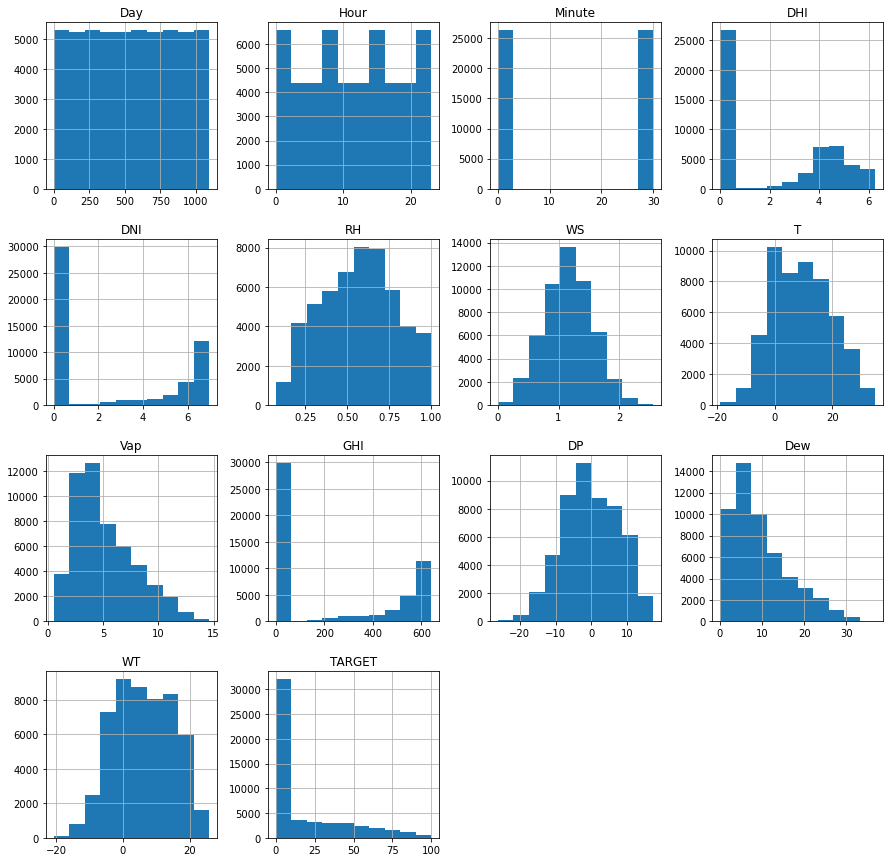

In [11]:
train.hist(figsize = (15, 15))

<AxesSubplot:>

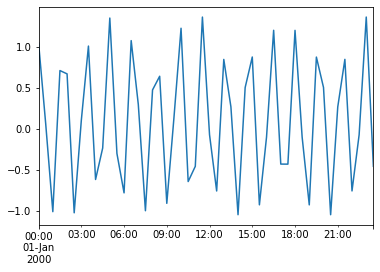

In [104]:
alpha[:48].plot()

In [8]:
train.corr()

Day      Hour    Minute       DHI       DNI        RH  \
Day         1.000000  0.000000  0.000000 -0.015857  0.010867 -0.125894   
Hour        0.000000  1.000000  0.000000  0.031881 -0.005209 -0.084317   
Minute      0.000000  0.000000  1.000000 -0.002356 -0.004035  0.008900   
DHI        -0.015857  0.031881 -0.002356  1.000000  0.851102 -0.621328   
DNI         0.010867 -0.005209 -0.004035  0.851102  1.000000 -0.634782   
RH         -0.125894 -0.084317  0.008900 -0.621328 -0.634782  1.000000   
WS          0.030755 -0.077574 -0.007025  0.280416  0.244778 -0.246023   
T           0.068151  0.105613 -0.007691  0.519786  0.461636 -0.532153   
Vap        -0.025204  0.057008 -0.000711  0.041230 -0.040886  0.238603   
GHI         0.021427 -0.018025 -0.000904  0.651257  0.899455 -0.612430   
DP         -0.016795  0.065640 -0.001781  0.106132  0.020388  0.169705   
Dew         0.116950  0.080872 -0.009174  0.635528  0.645310 -0.955422   
WT          0.047522  0.100330 -0.006433  0.430637  0.360956 -0.359850   
TARGET     -0.003624  0.003799 -0.000229  0.777069  0.830060 -0.677110   
NEW_TARGET -0.001542  0.003788 -0.000229  0.781854  0.668342 -0.620747   

                  WS         T       Vap       GHI        DP       Dew  \
Day         0.030755  0.068151 -0.025204  0.021427 -0.016795  0.116950   
Hour       -0.077574  0.105613  0.057008 -0.018025  0.065640  0.080872   
Minute     -0.007025 -0.007691 -0.000711 -0.000904 -0.001781 -0.009174   
DHI         0.280416  0.519786  0.041230  0.651257  0.106132  0.635528   
DNI         0.244778  0.461636 -0.040886  0.899455  0.020388  0.645310   
RH         -0.246023 -0.532153  0.238603 -0.612430  0.169705 -0.955422   
WS          1.000000  0.047779 -0.146838  0.219379 -0.126515  0.207618   
T           0.047779  1.000000  0.640831  0.403993  0.723214  0.654400   
Vap        -0.146838  0.640831  1.000000 -0.100362  0.965615 -0.130441   
GHI         0.219379  0.403993 -0.100362  1.000000 -0.045527  0.634113   
DP         -0.126515  0.723214  0.965615 -0.045527  1.000000 -0.048943   
Dew         0.207618  0.654400 -0.130441  0.634113 -0.048943  1.000000   
WT         -0.000085  0.979582  0.773928  0.297437  0.847294  0.489019   
TARGET      0.241193  0.562260 -0.003196  0.835026  0.068372  0.738298   
NEW_TARGET  0.255130  0.545128  0.032982  0.599071  0.100702  0.678125   

                  WT    TARGET  NEW_TARGET  
Day         0.047522 -0.003624   -0.001542  
Hour        0.100330  0.003799    0.003788  
Minute     -0.006433 -0.000229   -0.000229  
DHI         0.430637  0.777069    0.781854  
DNI         0.360956  0.830060    0.668342  
RH         -0.359850 -0.677110   -0.620747  
WS         -0.000085  0.241193    0.255130  
T           0.979582  0.562260    0.545128  
Vap         0.773928 -0.003196    0.032982  
GHI         0.297437  0.835026    0.599071  
DP          0.847294  0.068372    0.100702  
Dew         0.489019  0.738298    0.678125  
WT          1.000000  0.452309    0.448545  
TARGET      0.452309  1.000000    0.817702  
NEW_TARGET  0.448545  0.817702    1.000000

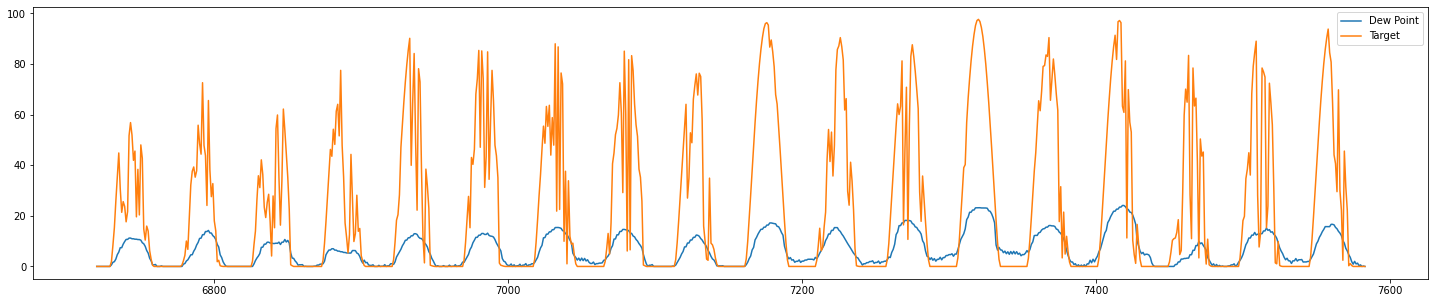

In [12]:
plt.figure(figsize = (25, 5))
start = 48*140
end = 48*158
train["Dew"][start:end].plot(label = "Dew Point")
train["TARGET"][start:end].plot(label = "Target")
plt.legend()

In [6]:
data = go.Scatter3d(x = train.dropna()["DHI"].iloc[48*30:48*210], y = train.dropna()["DNI"].iloc[48*30:48*210], z = train.dropna()["NEW_TARGET"].iloc[48*30:48*210], mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True, showlegend = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

'temp-plot.html'

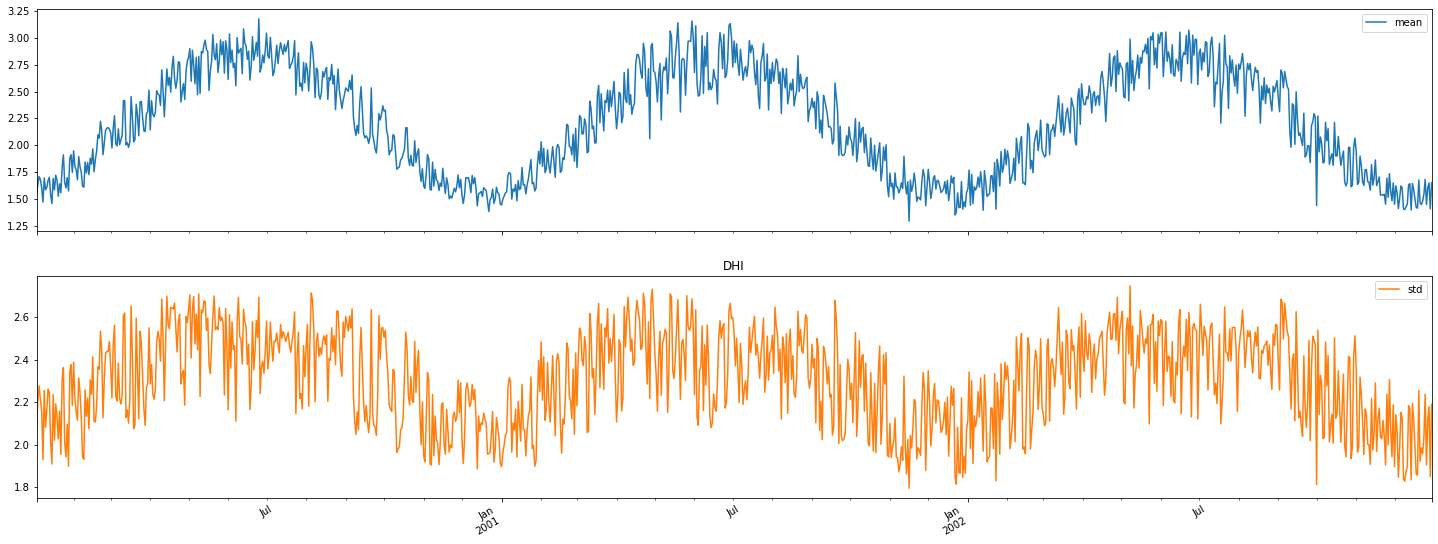

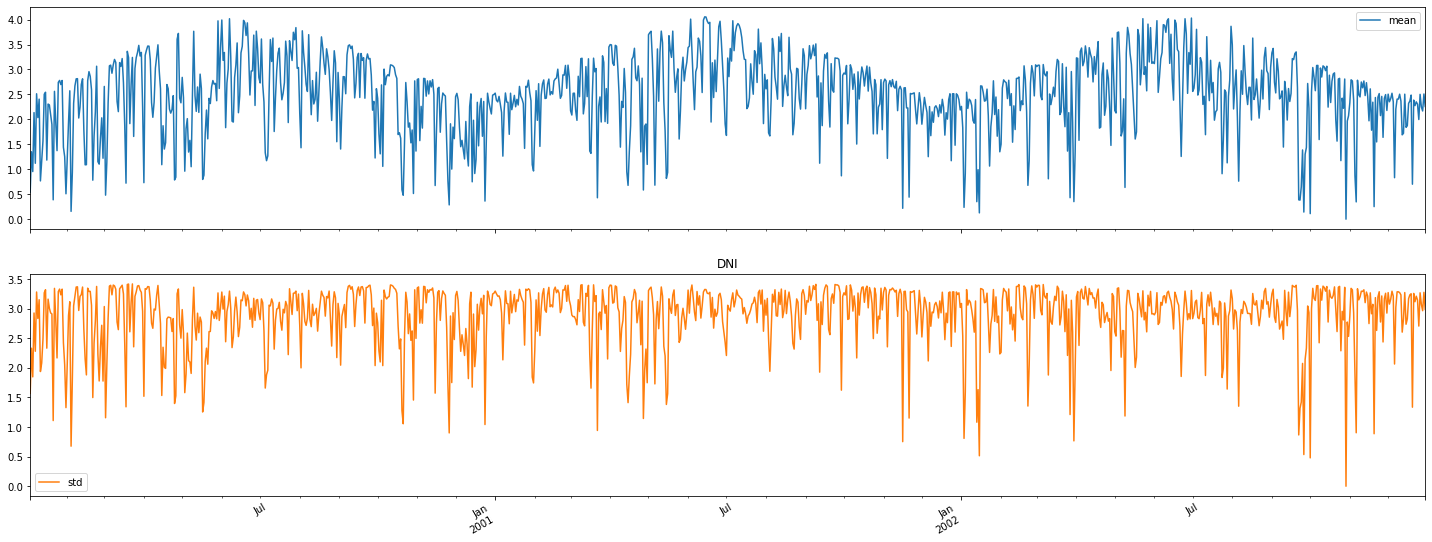

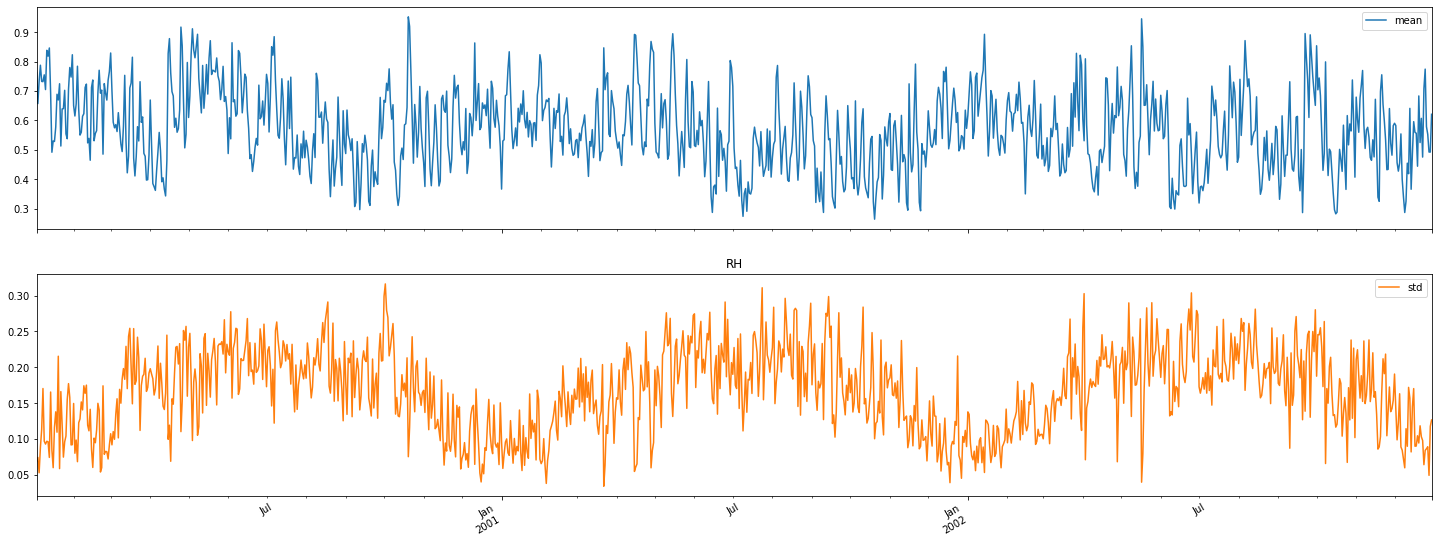

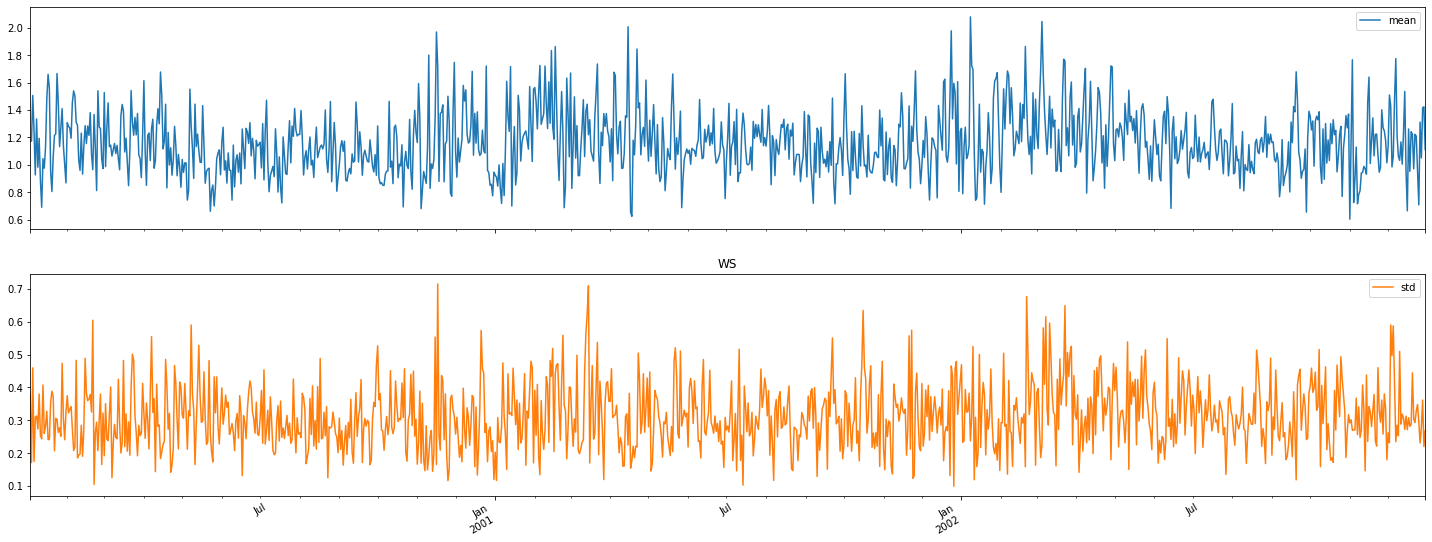

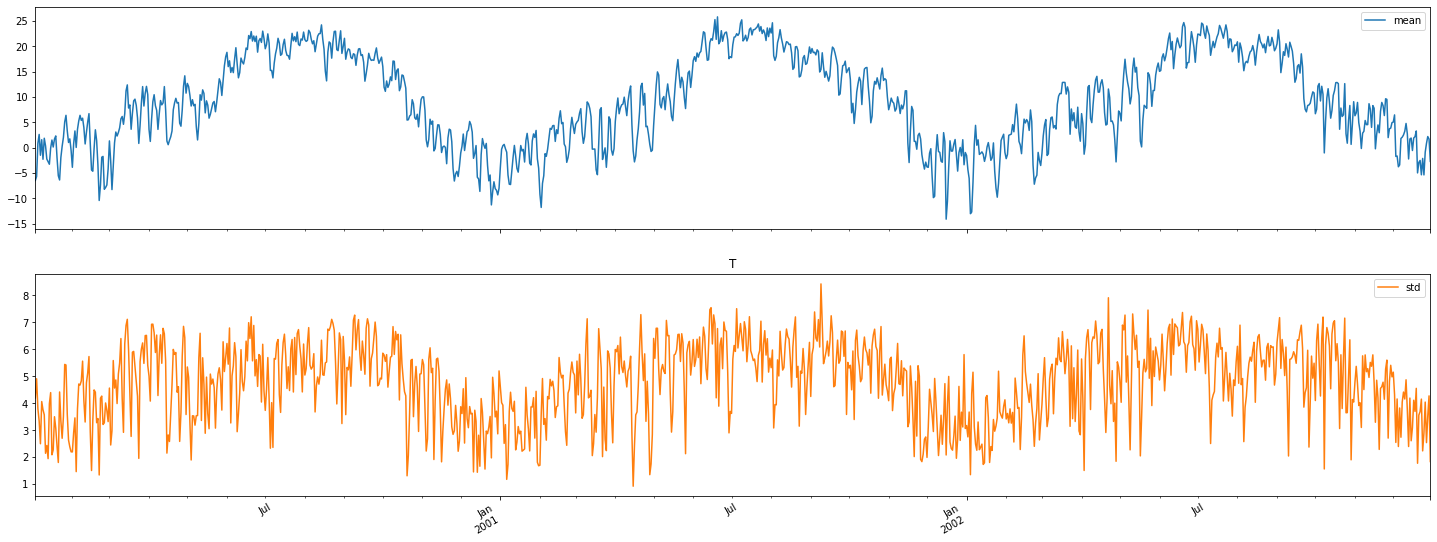

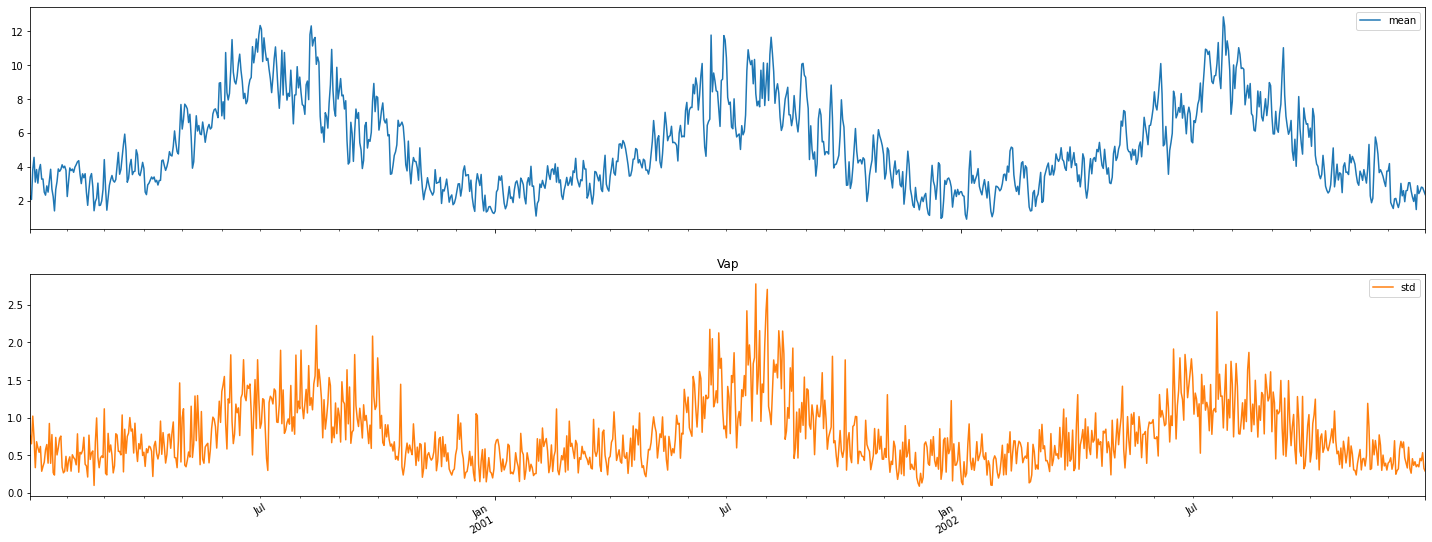

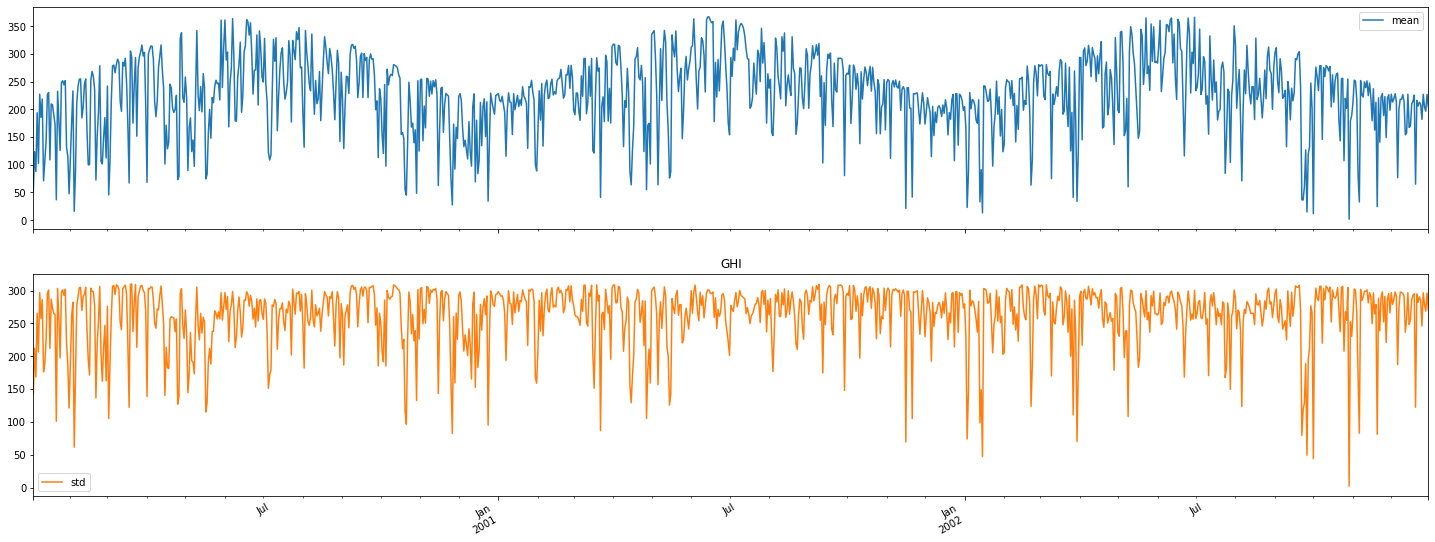

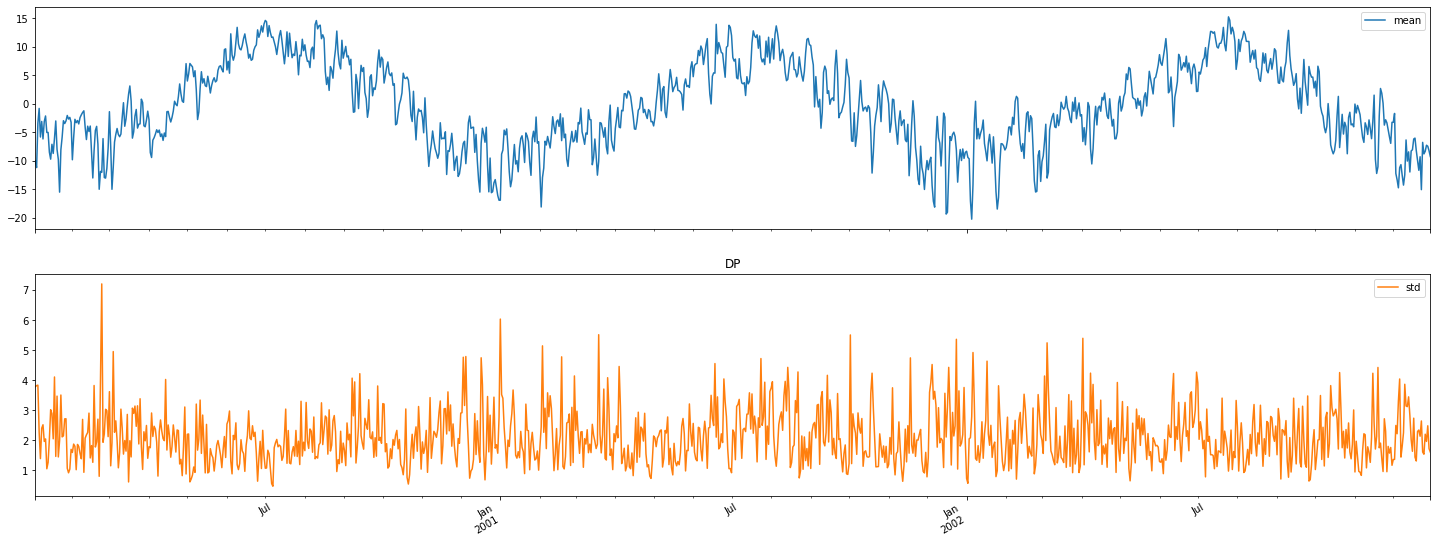

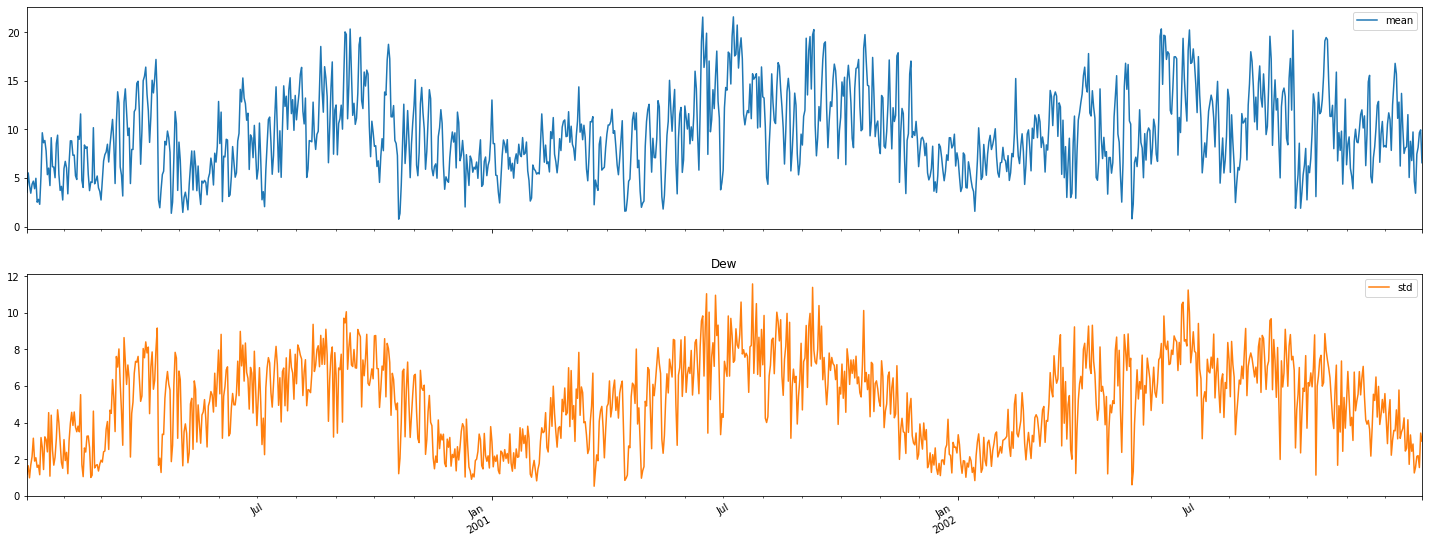

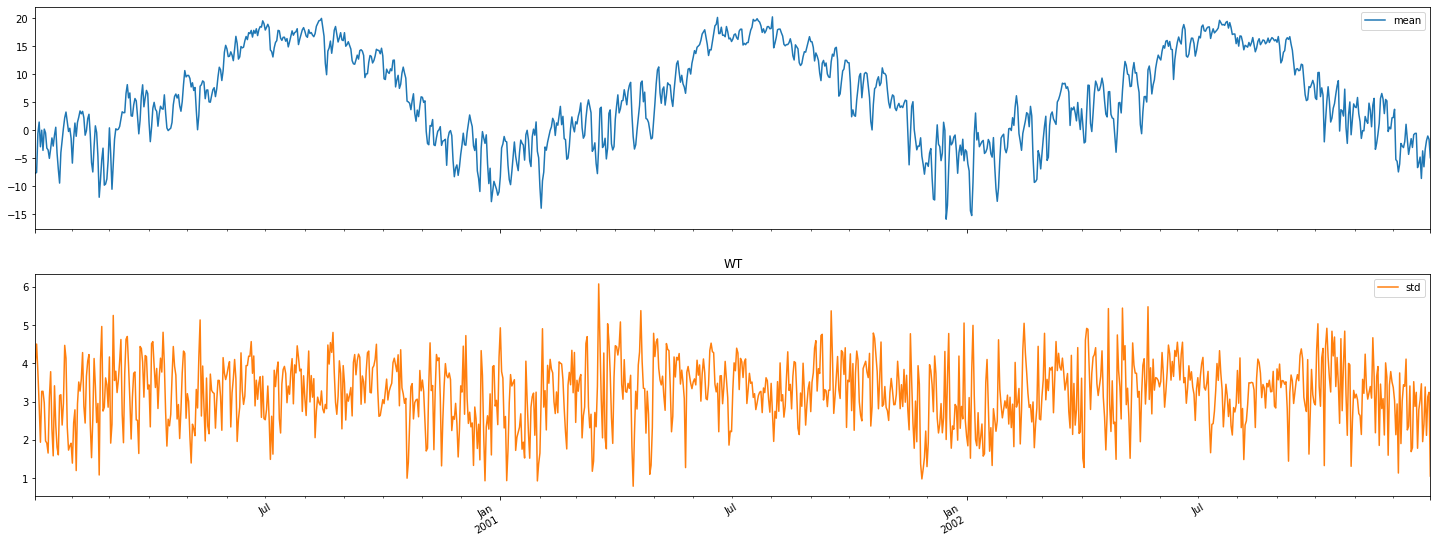

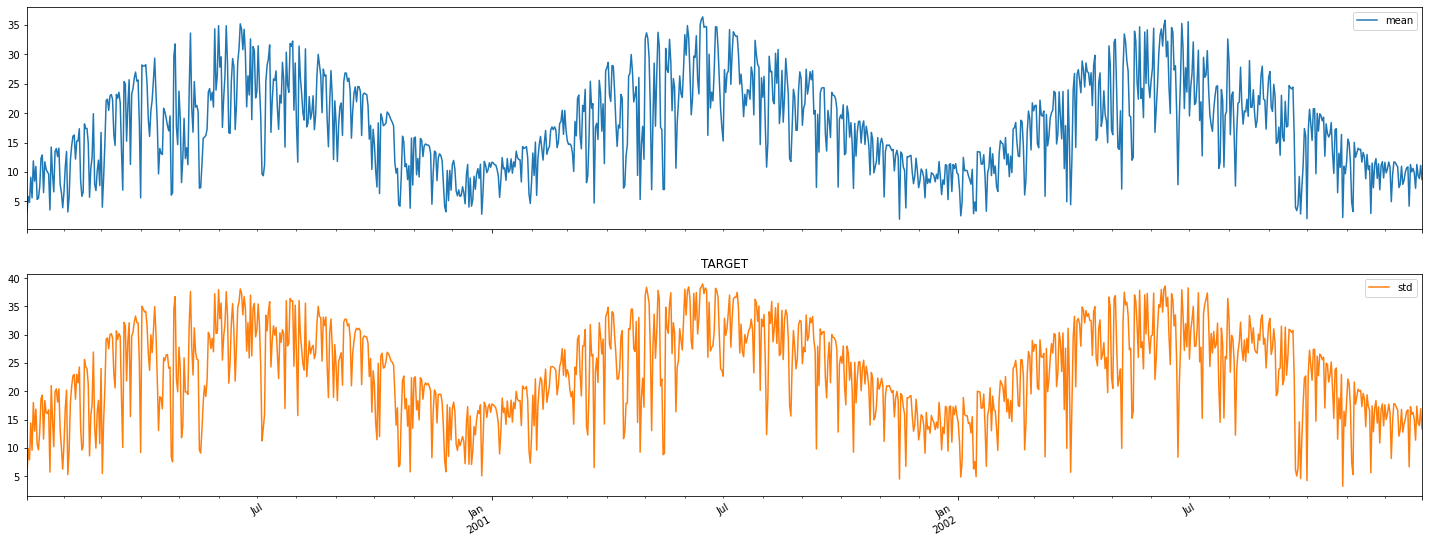

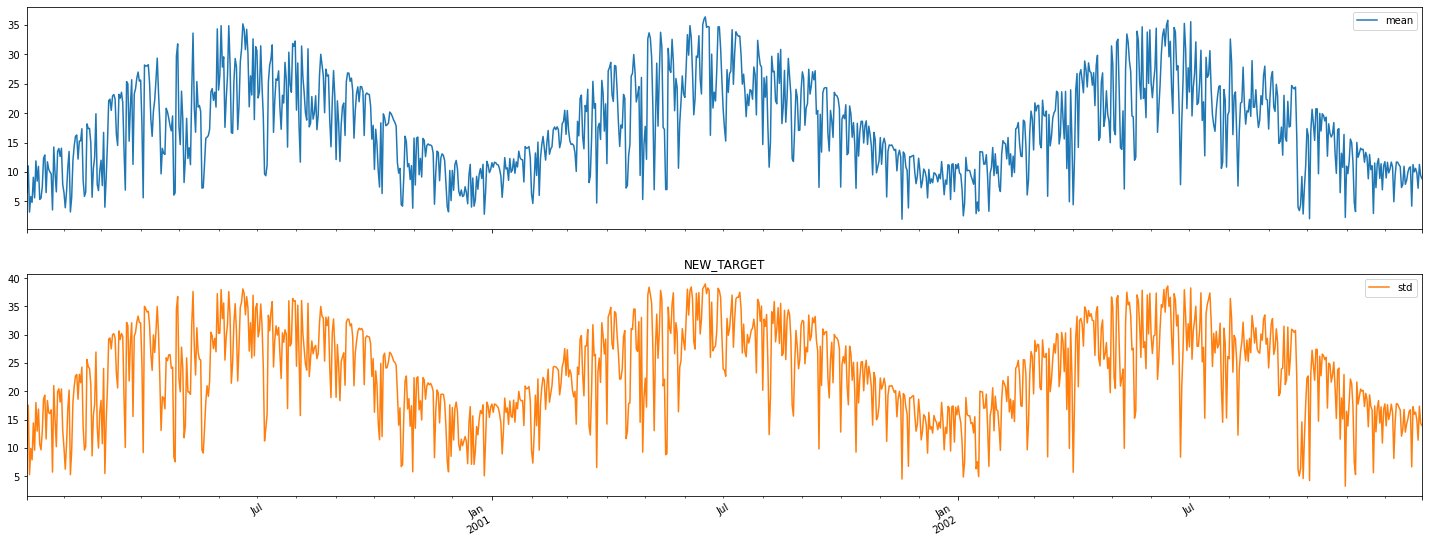

In [16]:
for i in train.columns[3:] :
    train.resample("D").agg(["mean", "std"])[i].plot(subplots = True, figsize = (25, 10))
    plt.title(i)

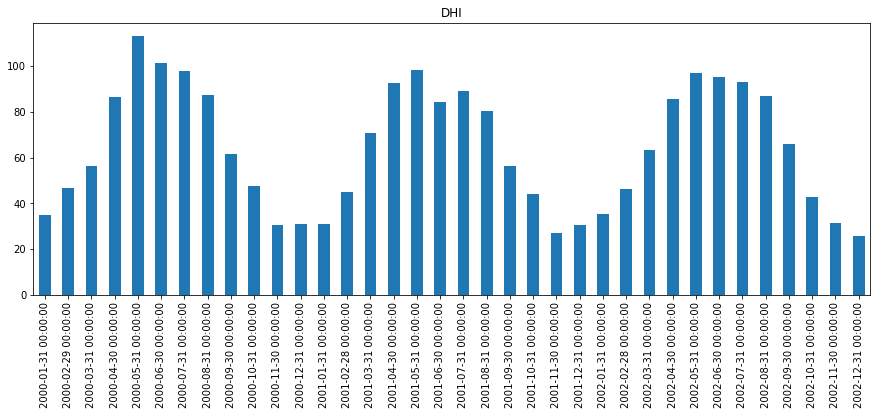

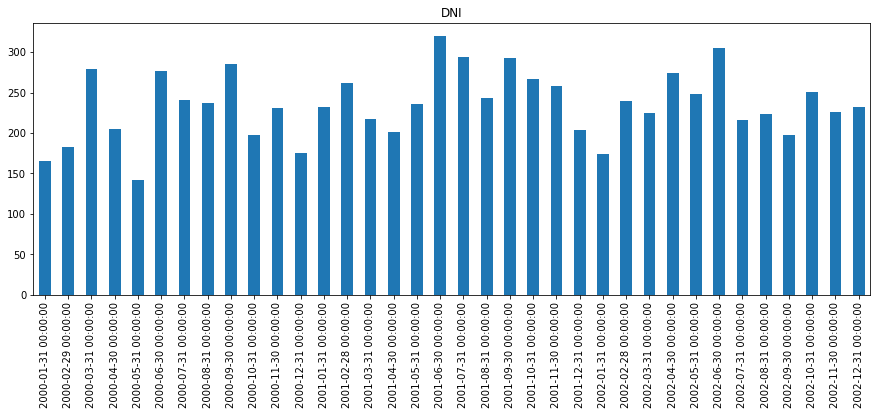

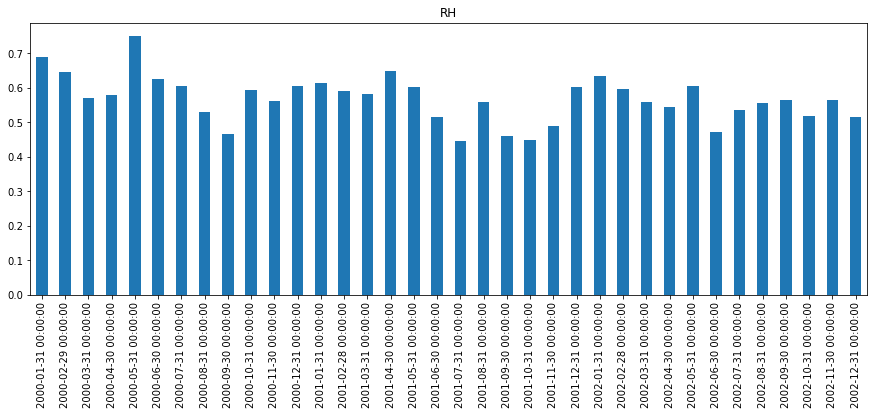

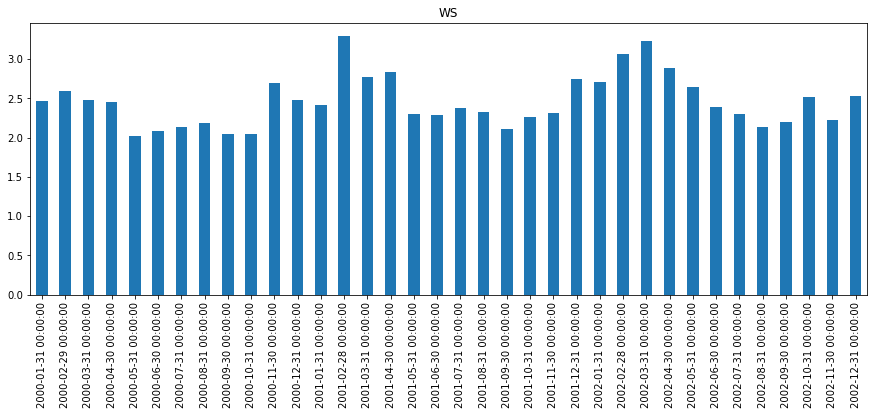

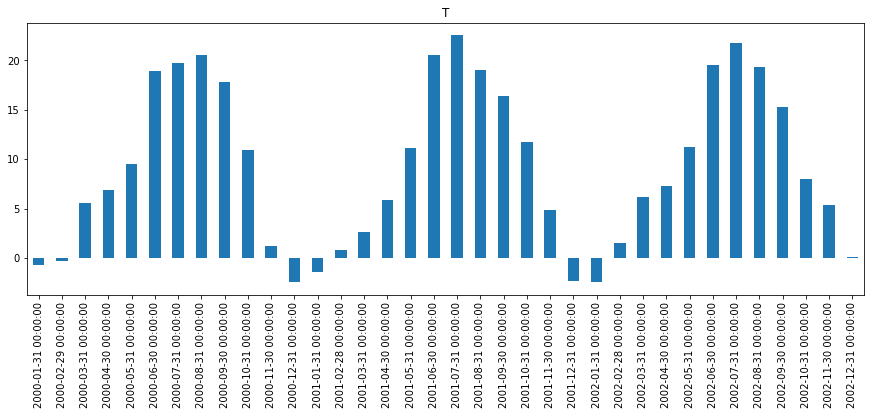

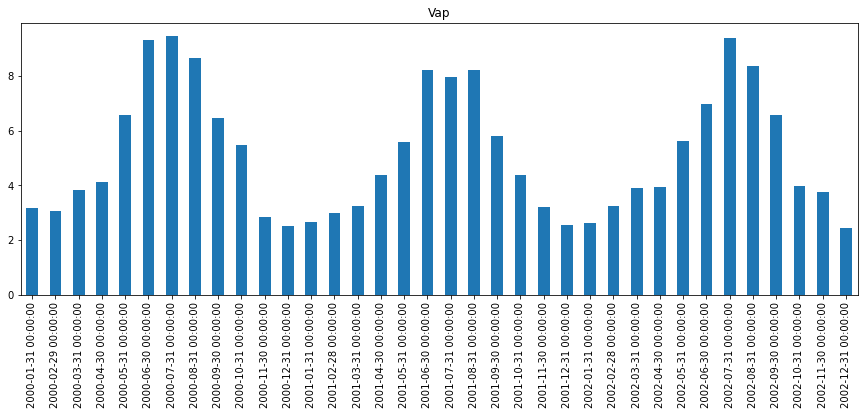

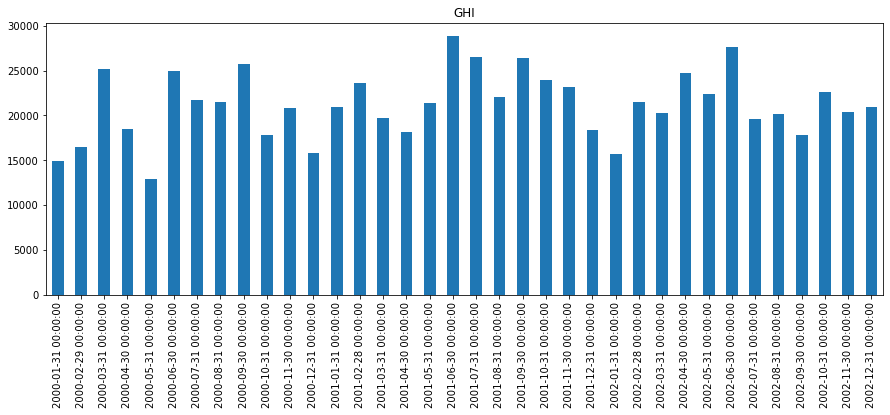

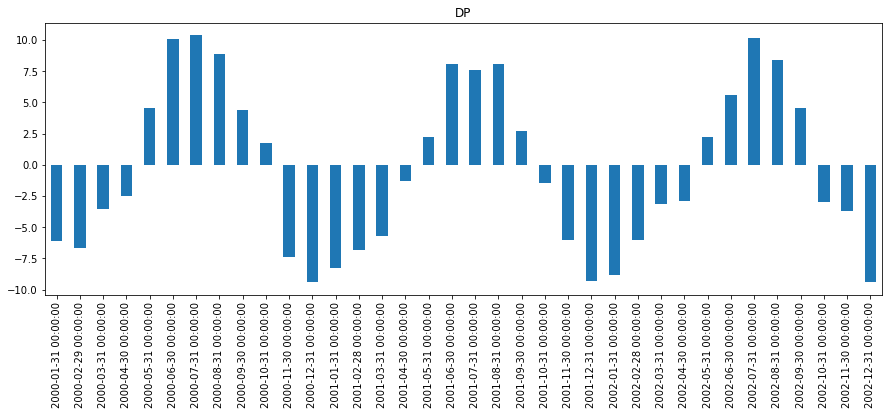

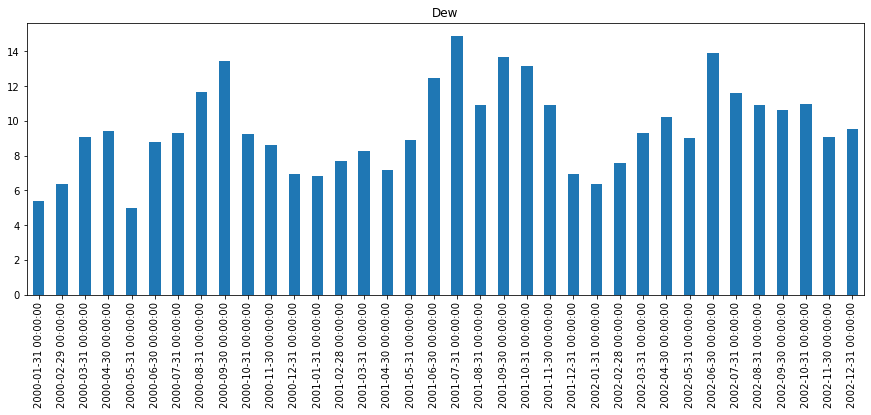

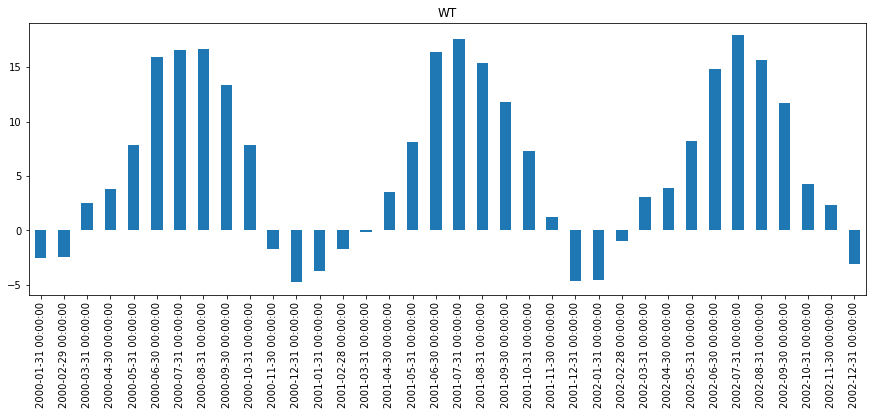

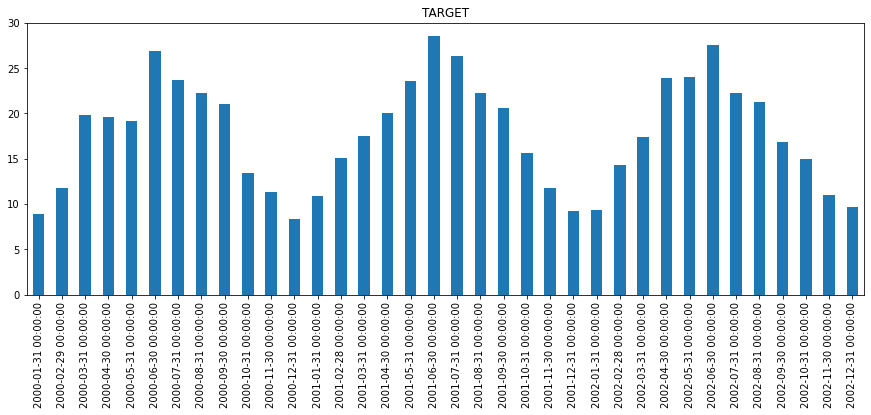

In [9]:
for i in train.columns[3:] :
    train.resample("M").mean()[i].plot(kind = "bar", figsize = (15, 5))
    plt.title(i)
    plt.show()

In [ ]:
# https://seoncheolpark.github.io/book/_book/36-1-quantile.html
# 분위수 회귀 공부하자

<AxesSubplot:>

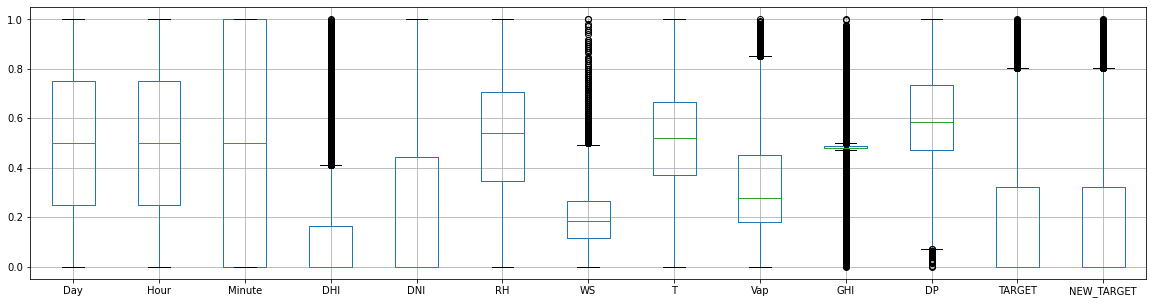

In [92]:
train.boxplot(figsize = (20, 5))

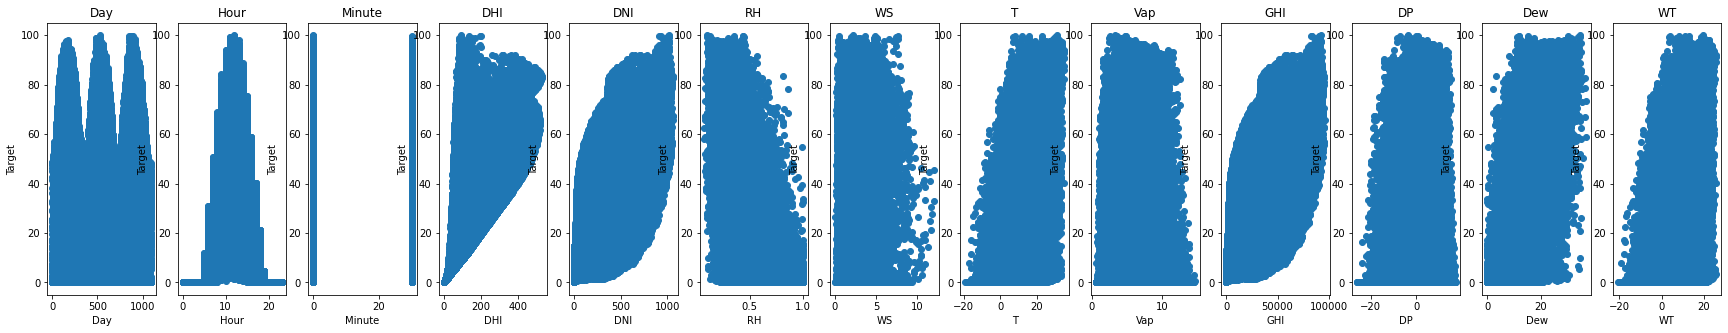

In [10]:
feature = train.columns.drop("TARGET")
target = train["TARGET"]

plt.figure(figsize = (30, 5))
for i, col in enumerate(feature) :
    plt.subplot(1, len(feature), i+1)
    x = train[col]
    y = target
    
    plt.scatter(x, y, marker = 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Target")
    
# Day는 3년을 기점으로 굴러가니, 봄 여름 가을 겨울 순으로 전력 생산량이 움직임
# 연도 별 차이는 없어보임
# 시간은 정규분포모양
# 당연히 한 낮 발전량이 가장 높고 일몰 후에는 발전량 X
# 일사량 분석 필요
# 풍속은 너무 높지만 않으면 큰 차이 없어보임
# 습도는 어느정도 수준 이상 높아지면 높아질 수록 떨어짐 (비 와서 해가 안보이니까)
# 온도는 어느 정도 높아지면 별 차이 없어짐


array([[<AxesSubplot:xlabel='Day', ylabel='Day'>,
        <AxesSubplot:xlabel='Hour', ylabel='Day'>,
        <AxesSubplot:xlabel='Minute', ylabel='Day'>,
        <AxesSubplot:xlabel='DHI', ylabel='Day'>,
        <AxesSubplot:xlabel='DNI', ylabel='Day'>,
        <AxesSubplot:xlabel='RH', ylabel='Day'>,
        <AxesSubplot:xlabel='WS', ylabel='Day'>,
        <AxesSubplot:xlabel='T', ylabel='Day'>,
        <AxesSubplot:xlabel='Vap', ylabel='Day'>,
        <AxesSubplot:xlabel='GHI', ylabel='Day'>,
        <AxesSubplot:xlabel='DP', ylabel='Day'>,
        <AxesSubplot:xlabel='Dew', ylabel='Day'>,
        <AxesSubplot:xlabel='WT', ylabel='Day'>,
        <AxesSubplot:xlabel='TARGET', ylabel='Day'>],
       [<AxesSubplot:xlabel='Day', ylabel='Hour'>,
        <AxesSubplot:xlabel='Hour', ylabel='Hour'>,
        <AxesSubplot:xlabel='Minute', ylabel='Hour'>,
        <AxesSubplot:xlabel='DHI', ylabel='Hour'>,
        <AxesSubplot:xlabel='DNI', ylabel='Hour'>,
        <AxesSubplot:xlabel='RH', ylabe

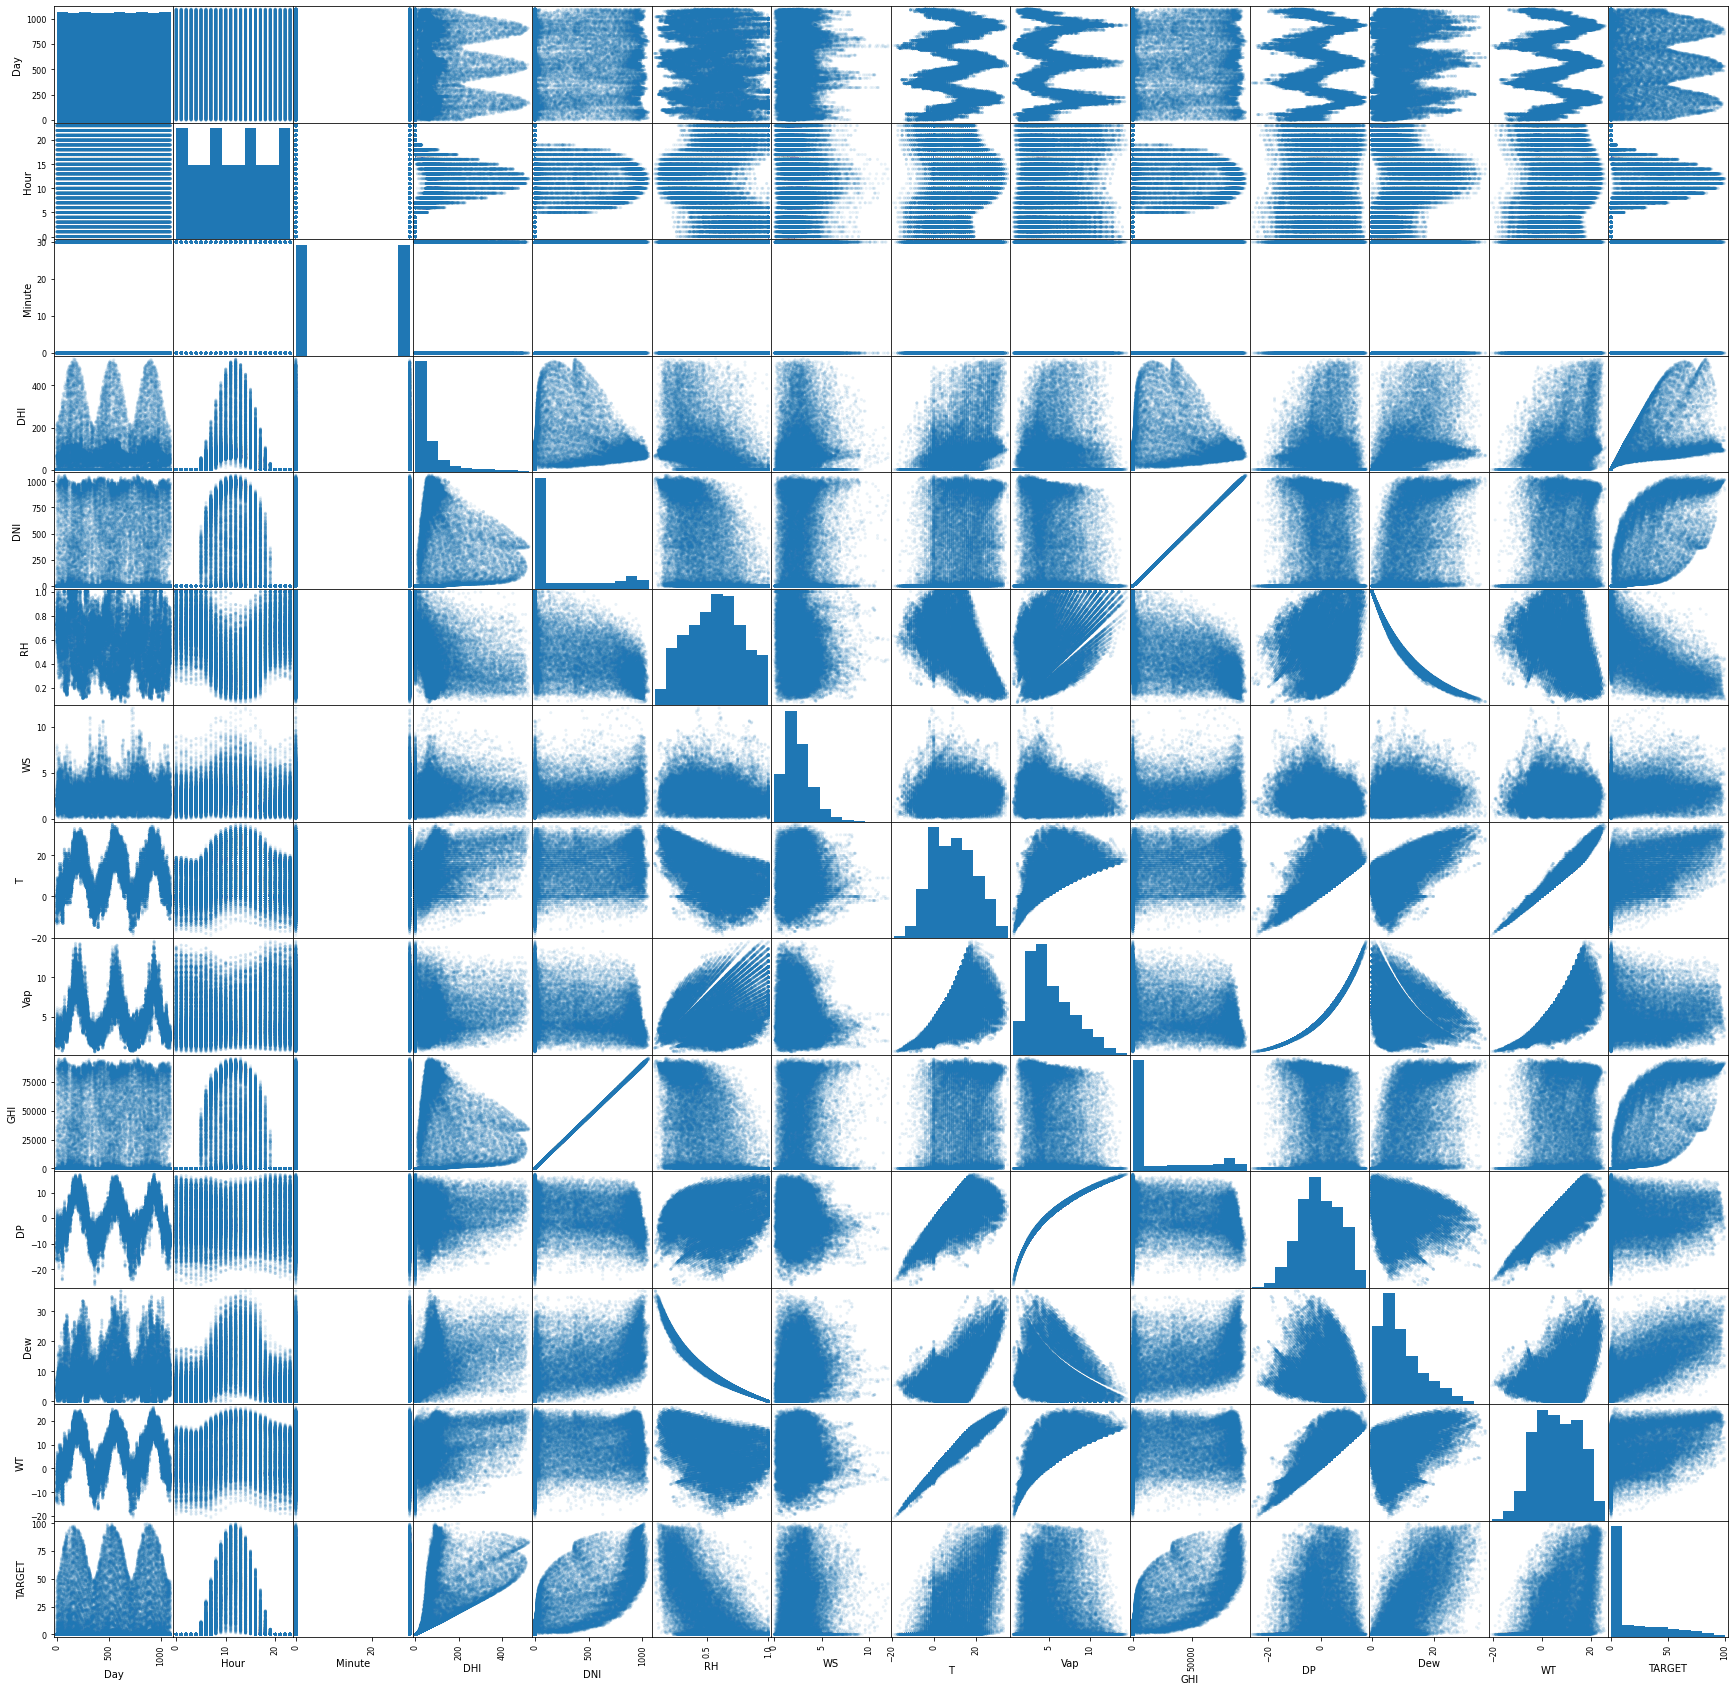

In [14]:
pd.plotting.scatter_matrix(train, figsize = (30, 30), alpha = .1)

<AxesSubplot:>

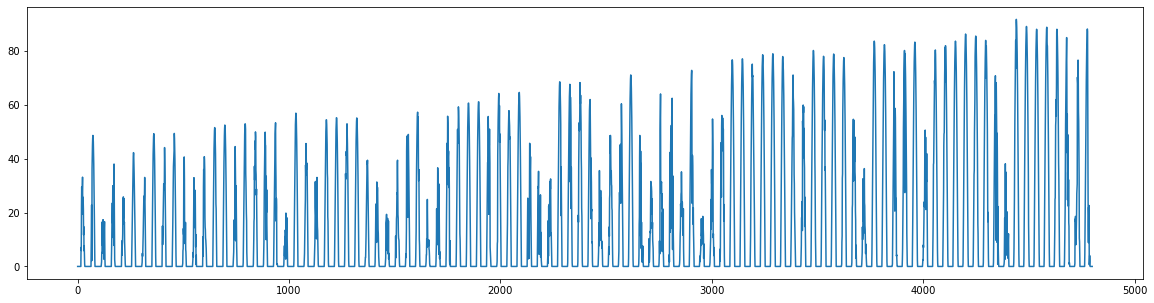

In [7]:
plt.figure(figsize = (20, 5))
train["TARGET"].iloc[:48*100].plot(kind = "line")

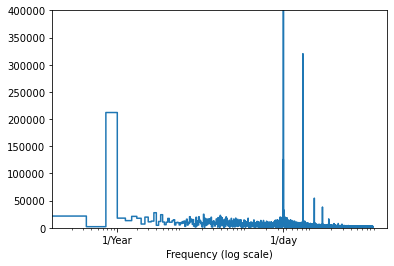

In [23]:
fft = tf.signal.rfft(train['TARGET'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train['TARGET'])
hours_per_year = 48*365
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')